### Objective
Define a simple model with two factors - calendar (seasonality) and flow.  Maybe 10 features.




In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from IPython.core.display import Image

## The below imports interface to my (proprietary)
## price database.  Replace this code with your own
## source for downloading price data

import sys
sys.path.append('/anaconda/')
import config
sys.path.append(config.REPO_ROOT + 'data/')
from prices.eod import read
from prices.eod import iqfeed
from prices.eod.read import get_adjustment_factors



date
1993-02-01    0.007087
1993-02-02    0.002116
1993-02-03    0.010515
1993-02-04    0.004175
1993-02-05   -0.000695
Name: SPY, dtype: float64


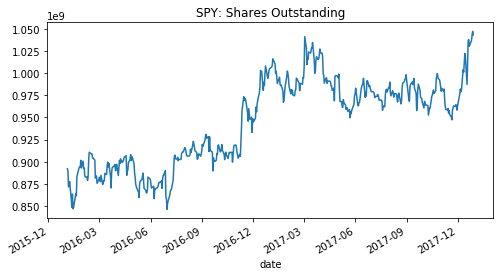

In [6]:
def make_data(symbols):
    
    price = iqfeed.read_etf_daily(symbols)
    so = iqfeed.read_etf_so(symbols) #shares outstanding
    df = price[['close']].join(so)
    df.loc[df.so==0,'so'] = None
    df.so = df.so.ffill() # handle days of unreported shares out 
    df = df[df.so>0]

    adj_factors = get_adjustment_factors(symbols).stack()
    adj_factors.name = 'adj_factors'

    df['close_adj'] = df.close * adj_factors
    df['daily_ret_adj'] = df.close_adj.groupby(level='symbol').pct_change()
    df['log_ret_adj'] = np.log(df.close_adj).groupby(level='symbol').diff()
    df['flow'] = np.log(df.so).groupby(level='symbol').diff()
    df['mkt_cap_adj'] = df.so*df.close_adj

    # catch outliers
    df = df[df.daily_ret_adj.abs()<0.25] # daily price changes of >25%
    df = df[df.so.pct_change().abs()<0.50] # shares outstanding change of >50%

    # standardize time frame
    df = df.xs(slice('2000-01-01','2017-12-31'),level='date',drop_level=False)
    
    return df.copy()

df = make_data(['SPY'])
df.xs('SPY',level='symbol')['2016':].so.plot(title='SPY: Shares Outstanding',figsize=(8,4))

In [227]:
import scikitplot as skplt
from sklearn.linear_model import LassoCV,LinearRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.preprocessing import normalize

In [251]:
df.dropna(inplace=True)
X = df.drop(columns='outcome')

In [264]:
df = make_data(['SPY'])

df['outcome'] = df.close_adj.pct_change(-1)
df['moy'] = df.index.get_level_values('date').month
df['dow'] = df.index.get_level_values('date').weekday
df['dom'] = df.index.get_level_values('date').day

df = df.join(pd.get_dummies(df['moy'],prefix='moy'))
df = df.join(pd.get_dummies(df['dom'],prefix='dom'))
df = df.join(pd.get_dummies(df['dow'],prefix='dow'))

df.dropna(inplace=True)
y_true = df['outcome']
X = df.drop(columns=['outcome','close','close_adj','mkt_cap_adj','daily_ret_adj','so'])
#X = df[['flow','daily_ret_adj','moy','dow','dom']]
#X = normalize(X)

true = pd.qcut(y_true,3,labels=[-1,0,1])
true.tail()

date        symbol
2017-12-21  SPY       0
2017-12-22  SPY       0
2017-12-26  SPY       0
2017-12-27  SPY       0
2017-12-28  SPY       1
Name: outcome, dtype: category
Categories (3, int64): [-1 < 0 < 1]

In [265]:
#clf = LogisticRegressionCV(class_weight='balanced',fit_intercept=True)
clf = RandomForestClassifier(class_weight='balanced',max_depth=3)
#clf = ExtraTreeClassifier(max_depth=5,class_weight='balanced')
#clf = DecisionTreeClassifier(class_weight={1:0.33,0:0.34,-1:0.33},max_depth=3)
print(clf.fit(y=true,X=X ))
print()
print('## # # # # # # # # # ## ######')
print()
print(pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False))
#print(pd.DataFrame(clf.coef_.T,index=X.columns))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## # # # # # # # # # ## ######

log_ret_adj    0.273941
moy            0.107361
flow           0.101993
dom            0.082714
dow            0.049049
dom_21         0.036985
dom_17         0.034144
dom_13         0.024211
dom_3          0.022918
dow_2          0.021421
dow_0          0.019352
dom_20         0.018421
moy_6          0.018403
moy_9          0.017292
moy_7          0.016474
moy_11         0.016417
moy_3          0.012354
moy_8          0.011034
dom_19         0.010769
dom_25         0.010688
dom_4          0.010122
dom_6          0.009742
dom_22         

In [267]:
pred = clf.predict(X)
proba = clf.predict_proba(X)

(array([1133.,    0.,    0.,    0.,    0., 1944.,    0.,    0.,    0.,
        1168.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

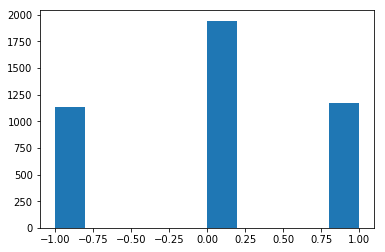

In [268]:
plt.hist(pred)


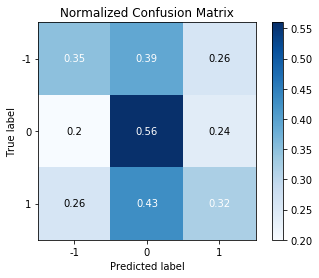

In [271]:
skplt.metrics.plot_confusion_matrix(
    y_true=true,
    y_pred=pred,
    normalize=True)

(array([ 838.,    0.,    0.,    0.,    0., 1889.,    0.,    0.,    0.,
        1504.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

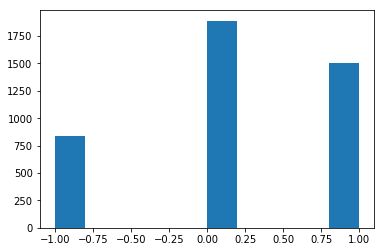

In [214]:
plt.hist(pred)

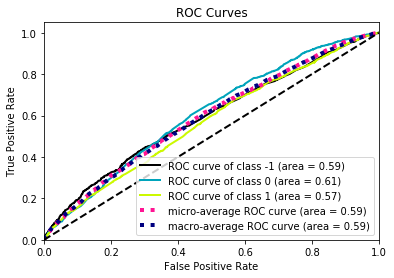

In [272]:
skplt.metrics.plot_roc(y_true=true,y_probas=proba)

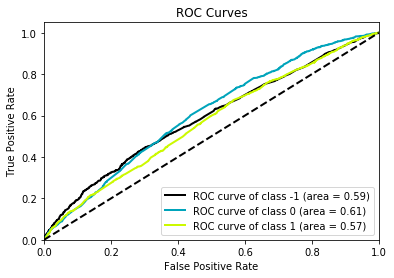

In [273]:
skplt.metrics.plot_roc(y_true=true,y_probas=proba,classes_to_plot=[1,0,-1],plot_micro=False,plot_macro=False)

In [41]:
skplt.metrics.plot_roc(y_true=true,y_probas=proba)

[(-0.000569, -0.000193], (-0.01083, -0.000569], (-0.01083, -0.000569], (0.000297, 0.00294], (-0.01083, -0.000569], ..., (-0.000569, -0.000193], (-0.000193, 9.04e-06], (-0.000193, 9.04e-06], (-0.000193, 9.04e-06], (-0.000569, -0.000193]]
Length: 4243
Categories (5, interval[float64]): [(-0.01083, -0.000569] < (-0.000569, -0.000193] < (-0.000193, 9.04e-06] < (9.04e-06, 0.000297] < (0.000297, 0.00294]]